In [32]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os, cv2
import pandas as pd
import seaborn as sns
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

INPUT_SIZE = 256
POOLING = 'avg'

In [33]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [34]:
SAMPLE_PER_CATEGORY = 200
SEED = 1987
data_dir = '../input/plant-seedlings-classification/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [35]:
sample_submission.head(2)

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet


In [36]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [37]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.head(2)
train.shape

(4750, 3)

# Training sample

In [38]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.head(2)
train.shape

(2400, 3)

In [39]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head(2)
test.shape

(794, 2)

In [71]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

# Example images

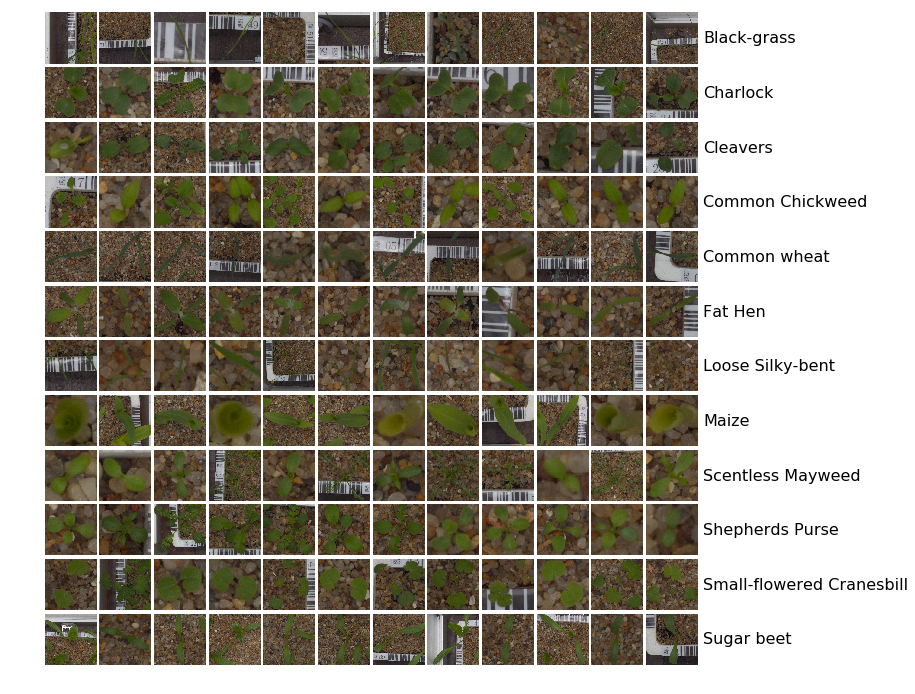

In [110]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

# Validation split

In [105]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(train))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(1899, 501)

In [106]:
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in tqdm(enumerate(train['file'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    x = np.expand_dims(img.copy(), axis=0)
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

2400it [00:32, 73.48it/s]

Train Images shape: (2400, 256, 256, 3) size: 471,859,200


In [107]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]

### Simple Convnet

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dropout
from keras.layers import Activation, Flatten
from keras.layers import Dense
from keras.utils import to_categorical

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                     input_shape=(INPUT_SIZE,INPUT_SIZE,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
ytr = to_categorical(ytr)
yv = to_categorical(yv)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

In [ ]:
model.fit(Xtr, ytr, epochs = 5, batch_size = 24,
                validation_data=(Xv, yv))

## Extract Xception bottleneck features

In [108]:
def load_images(preprocess_fn):
    x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
    for i, file in tqdm(enumerate(train['file'])):
        img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
        x = preprocess_fn(np.expand_dims(img.copy(), axis=0))
        x_train[i] = x
    print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))
    return x_train

def flatten_features(train, val):
    new_train_x_bf = []
    new_val_x_bf = []
    for features in train:
        new_train_x_bf.append(features.ravel())
    
    for features in val:
        new_val_x_bf.append(features.ravel())
    return new_train_x_bf, new_val_x_bf

ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values

In [ ]:
from keras.applications.xception import Xception, preprocess_input

In [ ]:
x_train = load_images(preprocess_input)
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))

In [ ]:
print(Xtr.shape)

In [ ]:
xception_bottleneck = Xception(input_shape=(INPUT_SIZE,INPUT_SIZE,3), 
                                            weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

## LogReg on Xception bottleneck features

In [ ]:
log = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 10000, random_state=SEED)
log.fit(train_x_bf, ytr)

In [ ]:
valid_preds = log.predict(valid_x_bf)

In [ ]:
print('Validation Xception Accuracy {}'.format(accuracy_score(yv, valid_preds)))

## SVM on Xception bottleneck features

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm = SVC()
svm.fit(train_x_bf, ytr)

In [ ]:
valid_preds = svm.predict(valid_x_bf)

In [ ]:
print('Validation Xception + SVM Accuracy {}'.format(accuracy_score(yv, valid_preds)))

### Resnet50

In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input

In [ ]:
x_train = load_images(preprocess_input)
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))

In [ ]:
resnet = ResNet50(input_shape=(INPUT_SIZE, INPUT_SIZE, 3), include_top=False, 
                        weights= 'imagenet', pooling='POOLING')

In [ ]:
train_x_bf = resnet.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = resnet.predict(Xv, batch_size=32, verbose=1)
print("Resnet train bottleneck features shape: {}".format(train_x_bf.shape))

In [ ]:
x_train, x_val = flatten_features(train_x_bf, valid_x_bf)

log = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000, random_state=SEED)
log.fit(x_train, ytr)

In [ ]:
valid_preds = log.predict(x_val)
print('Validation Resnet50 Accuracy {}'.format(accuracy_score(yv, valid_preds)))

### VGG16

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
x_train = load_images(preprocess_input)
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))

In [ ]:
vgg_conv = VGG16(weights='imagenet', include_top=False,
                 input_shape=(256, 256, 3))

train_x_bf = vgg_conv.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = vgg_conv.predict(Xv, batch_size=32, verbose=1)
print('VGG16 train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('VGG16 valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

In [ ]:
x_train, x_val = flatten_features(train_x_bf, valid_x_bf)

In [ ]:
log = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000, random_state=SEED)
log.fit(x_train, ytr)

In [ ]:
valid_preds = log.predict(x_val)
print('Validation VGG16 Accuracy {}'.format(accuracy_score(yv, valid_preds)))

### Inception

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [ ]:
x_train = load_images(preprocess_input)
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))

In [ ]:
vgg_conv = InceptionV3(weights='imagenet', include_top=False,
                 input_shape=(256, 256, 3))

train_x_bf = vgg_conv.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = vgg_conv.predict(Xv, batch_size=32, verbose=1)
print('VGG16 train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('VGG16 valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

In [ ]:
x_train, x_val = flatten_features(train_x_bf, valid_x_bf)

In [ ]:
log = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000, random_state=SEED)
log.fit(x_train, ytr)

In [ ]:
valid_preds = log.predict(x_val)
print('Validation Inception Accuracy {}'.format(accuracy_score(yv, valid_preds)))

## Confusion Matrix

In [ ]:
cnf_matrix = confusion_matrix(yv, valid_preds)

In [ ]:
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})

In [ ]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
#fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

In [101]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [102]:
filepath = '../input/plant-seedlings-classification/train/Maize/c6dc512e9.png'
image_bgr = cv2.imread(filepath, cv2.IMREAD_COLOR)

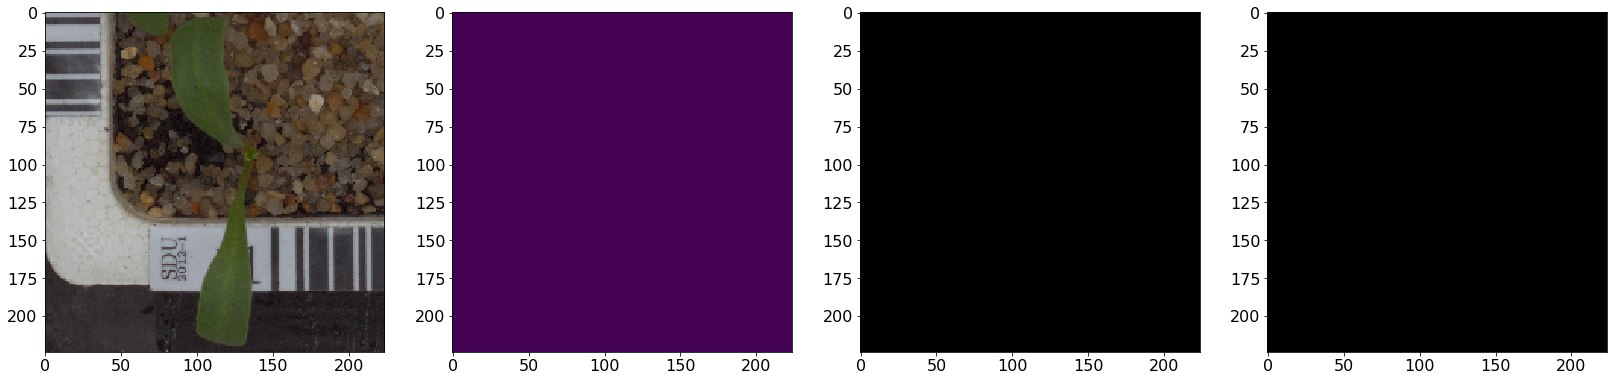

In [103]:
fig, ax = plt.subplots(1,4, figsize = (28, 28))
ax[0].imshow(img/ 255.)
ax[1].imshow(image_mask)
ax[2].imshow(image_segmented)
ax[3].imshow(image_sharpen)
plt.show()